# Microbial Dimensionality
In this notebook I calculate the dimensionality of simulated microbial consumption networks. The idea is based of Eklof 2013 who present an algorthm to detect the minimum number of dimensions required to represent a given network. This is also known in network science as boxicity. 

In [388]:
using Pkg

Pkg.activate("..")

using Distributions, LinearAlgebra, StatsBase, Distances
using CairoMakie

  Activating project at `~/Projects/Working/HIFMB/MiCRM_stability`


# Toy case
First we consider a toy case of a network with 3 consumers and 3 resources the question becomes how can we arrange the resources along $D$ 'niche' axes such that a $D$-dimension hypercube can be placed for each consumer which contains only its resources. 

The simplest case is when all consumers feed on a single seperate resource or nested subset:

$$
    \begin{bmatrix} 
        1 & 0 & 0 \\ 
        0 & 1 & 0 \\ 
        0 & 0 & 1 
    \end{bmatrix} 
    \quad 
    \begin{bmatrix} 
        1 & 1 & 1 \\ 
        0 & 1 & 0 \\ 
        0 & 0 & 1 
    \end{bmatrix}
$$

here resources can clearly be placed along a single axis. what if resources are not arranged like this?

$$
    \begin{bmatrix} 
        1 & 1 & 0 \\ 
        0 & 1 & 1 \\ 
        1 & 0 & 1 
    \end{bmatrix} 
$$

Here we can see that we need an aditional dimension. 


In [389]:
#type to contain all info to order and calucate error of that ordering
mutable struct Ordering
    N::Int64
    M::Int64
    D::Int64
    A::Matrix{Int64}
    A_boxy::Matrix{Int64}
    ord::Matrix{Int64}
    err::Int64
end

#calculate error of a given ordering
function calc_error!(o::Ordering)
    o.A_boxy .= 0.0
    for i = 1:o.N
        lims = zeros(o.D,2)
        for d = 1:o.D
            #get lims for each dimension
            diet_loc = o.ord[o.A[i,:] .== 1, o.D]
            if !isempty(diet_loc)
                lims = extrema(diet_loc)
                #calculate if resources are within range
                for k = 1:o.M
                    if lims[1] <= o.ord[k,o.D] <= lims[2]
                        o.A_boxy[i,k] += 1
                    end
                end
            end
        end
    end
    o.A_boxy = o.A_boxy .== o.D
    o.err = sum(o.A_boxy) - sum(o.A)
end

function swap!(o::Ordering, i,j,D)
    tmp = deepcopy(o.ord[i,D])
    o.ord[i,D] = copy(o.ord[j,D])
    o.ord[j,D] = tmp
end

#threshold accepting algo
function threshold_climb(o, Δ0, t_max)
    #define arrays
    Δvec = Int.(floor.(range(Δ0,0,t_max)))
    err_vec = fill(o.err, t_max + 1)
    #itterate 
    for t = 1:t_max
        #candidate swap
        D = rand(1:o.D)
        i,j = rand(1:o.M,2)

        #do swap
        swap!(o,i,j,D)
        calc_error!(o)
        
        #test if it is good
        if o.err - err_vec[t] <= Δvec[t]
            err_vec[t+1] = o.err
        else
            swap!(o,j,i,D)
            calc_error!(o)
            err_vec[t+1] = o.err
        end
        # println(o.err - err_vec[t],"  ",o.ord, "  ", o.err)
    end
    
    return(err_vec)
end
    

threshold_climb (generic function with 1 method)

In [410]:
using Random
Random.seed!(20)

#define case
N,M = 50,50
A = rand(N,M) .< 0.2
D = 15

#initial guesses
order = [hcat([sample(1:M,M, replace=false) for i = 1:D]...) for i = 1:8]

o = [Ordering(N,M,D,A,zeros(N,M),or,N*M) for or = order] 
calc_error!.(o)


8-element Vector{Int64}:
 1553
 1659
 1634
 1618
 1553
 1566
 1600
 1581

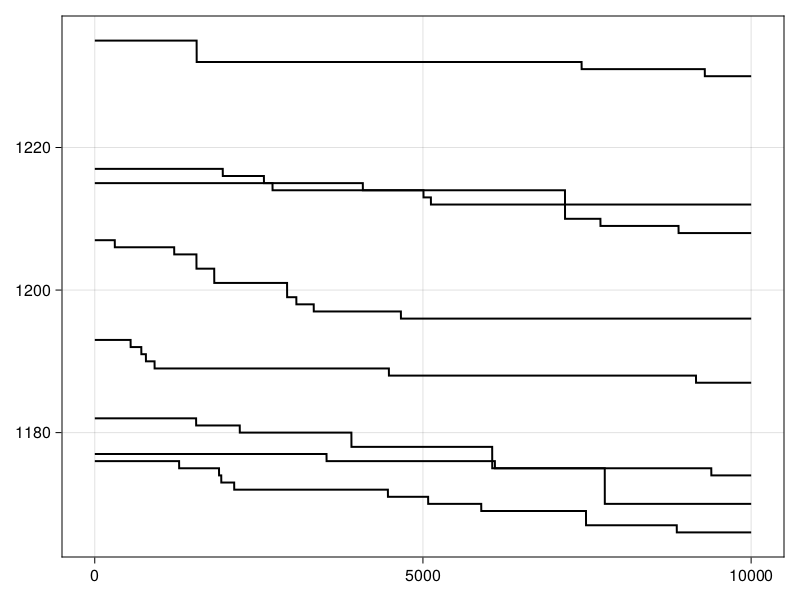

In [422]:
Nrep = 10000
res = zeros(8, Nrep+1)
Threads.@threads for i = 1:8
    res[i,:] .= threshold_climb(o[i], , Nrep)
end

series(res, solid_color = :black)

In [413]:
threshold_climb(o[1], 0, Nrep)

101-element Vector{Int64}:
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
    ⋮
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237
 1237

In [ ]:
C = readdlm("./data/C_mat.csv",',') .> 0